<a href="https://colab.research.google.com/github/vischia/lisbon-ml-school/blob/master/dataChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lisbon Machine Learning School
## Data Challenge!!! Multitarget regression

(C) Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch


## Setup the environment

- If you are running locally, you don't need to run anything

- If you are running on Google Colab, uncomment and run the next cell (remove only the "#", keep the "!"). You can also run it from a local installation, but it will do nothing if you have already installed all dependencies (and it will take some time to tell you it is not gonna do anything).

## Load the needed libraries

In [171]:
import os

import torch
import torch.nn as nn  
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
import torch.nn.functional as F 
import torchvision
import torchinfo
from tqdm import tqdm

import sklearn
import sklearn.model_selection
from sklearn.metrics import roc_curve, auc, accuracy_score

import uproot

import pandas as pd

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['axes.labelsize'] = 14
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.set_default_dtype(torch.float32)

print('Using torch version', torch.__version__)
print('Using device:', device)


Using torch version 2.6.0
Using device: mps


## Load the data

We will use the same data we used for exercise 2, that is simulated events corresponding to three physics processes.
- ttH production
- ttW production
- Drell-Yan ($pp\\to Z/\\gamma^*$+jets) production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%"/>

We use the [uproot](https://uproot.readthedocs.io/en/latest/basic.html) library to conveniently read in a [ROOT TNuple](https://root.cern.ch/doc/master/classTNtuple.html) which can automatically convert it to a [pandas dataframe](https://pandas.pydata.org/).

In [172]:
# # Download the data only if you haven't done so yet

# if not os.path.isfile("data/signal_blind20.root"): 
#     !mkdir data; cd data/; wget https://www.hep.uniovi.es/vischia/lisbon_ml_school/lisbon_ml_school_tth.tar.gz; tar xzvf lisbon_ml_school_tth.tar.gz; rm lisbon_ml_school_tth.tar.gz; cd -;


In [173]:

data = uproot.open('data/signal_blind20.root')['Friends'].arrays(library="pd")



## Data Inspection

Select the features you want to use for this exercise, don't forget to remove unnecessary features.

Most of the variables are input features, corresponding to detector measurements of the properties of the reconstructed decay products.

There are three special variables, though:

- `Hreco_evt_tag`: this feature has values in ${0,1}$, where $1$ flags the event as signal event, and $0$ flags the event as background event;
- `Hreco_HTXS_Higgs_pt`: this feature contains the true generate Higgs boson transverse momentum at generator level (used for regression);
- `Hreco_HTXS_Higgs_y`: this feature contains the true generated Higgs boson rapidity (not pseudorapidity) at generator level (used for regression).


### Important

Twenty percent of the events have `-99` in the `Hreco_HTXS_Higgs_pt` and `Hreco_HTXS_Higgs_y` values. These are the "unlabelled" events that you will have to send predictions for. You should filter them out for training and testing

## The assignment

- For this data challenge, your target is to simultaneously regress the Higgs transverse momentum `Hreco_HTXS_Higgs_pt` and the rapidity `Hreco_HTXS_Higgs_y`

- You will need to split your dataset into two parts: one is where you have access to the pT and y labels (80% of the dataset): you will build your training and test sets from this. The other is where the pT and y has been set to -99: this is the portion of data that is kept blind. You will have to use 80% of the data to train a regressor, then evaluate the output of your regressor on the blind 20% of the data, and send us the results. We will compare the result with the true value we have.

In [174]:
# Drop unneeded features

blind_data = data[data["Hreco_HTXS_Higgs_pt"]==-99]

train_val_data = data[data["Hreco_HTXS_Higgs_pt"]!=-99]
train_val_data = data[data["Hreco_Lep2_pt"]!=-99]

print(blind_data.shape[0] / data.shape[0])
print(train_val_data.shape[0] / data.shape[0])



train_val_labels = train_val_data[["Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"]].copy()

train_val_data = train_val_data.drop(["index", "Hreco_HTXS_Higgs_pt", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_Lep2_eta", "Hreco_Lep2_pt" , "Hreco_HTXS_Higgs_y", "Hreco_evt_tag"], axis=1 )

# Filter data
print(train_val_data.columns)
print(train_val_labels.columns)

from sklearn.preprocessing import StandardScaler# standard scaling
train_data, val_data, train_labels, val_labels = sklearn.model_selection.train_test_split(train_val_data, train_val_labels, test_size=0.1, random_state=42)

# Scale the train input features
for column in train_data.columns:
    scaler_train = StandardScaler().fit(train_data.filter([column], axis=1))
    train_data[column] = scaler_train.transform(train_data.filter([column], axis=1))

for column in val_data.columns:
    scaler_val = StandardScaler().fit(val_data.filter([column], axis=1))
    val_data[column] = scaler_val.transform(val_data.filter([column], axis=1))


# Scale the labels
for column in train_labels.columns:
    scaler_train_label = StandardScaler().fit(train_labels.filter([column], axis=1))
    train_labels[column] = scaler_train_label.transform(train_labels.filter([column], axis=1))

for column in val_labels.columns:
    scaler_val_label = StandardScaler().fit(val_labels.filter([column], axis=1))
    val_labels[column] = scaler_val_label.transform(val_labels.filter([column], axis=1))


0.19994854437379506
0.31147360226137455
Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_HadTop_eta',
       'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi', 'Hreco_More5_Jets_phi',
       'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass', 'Hreco_Lep1_mass',
       'Hreco_HadTop_mass', 'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi'],
      dtype='object')
Index(['Hreco_HTXS_Higgs_pt', 'Hreco_HTXS_Higgs_y'], dtype='object')


- The loss function typically used for regression problems is the mean square error: in this case you will have to figure out how to deal with the fact that the output vector has dimension two (transverse momentum, and rapidity).
- A tricky challenge is to deal with output features that have different scales: the rapidity is of $\mathcal{O}(1)$, the transverse momentum is of $\\mathcal{O}(100-1000}$

## Regression problems

Regression problems require the prediction to be free of adopting the same range as the target variable(s) that need to be regressed.

This is why the sigmoid activation function is not a good choice. The typical form of output layers of a regression problem is, if `n_outputs` is the dimension of the output vector:


In [175]:
class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label

batch_size=1024 # Minibatch learning


train_dataset = MyDataset(train_data, train_labels)
val_dataset = MyDataset(val_data, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([1024, 27])
Labels batch shape: torch.Size([1024, 2])


In [176]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.device = device
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128,64),
            nn.LeakyReLU(),
            nn.Linear(64,8),
            nn.LeakyReLU(),
            nn.Linear(8, 2),
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x

model = NeuralNetwork(train_data.shape[1])

print(model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(model, input_size=(batch_size, train_data.shape[1])) # the input size is (batch size, number of features)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=27, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=8, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=8, out_features=2, bias=True)
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1024, 2]                 --
├─Sequential: 1-1                        [1024, 2]                 --
│    └─Linear: 2-1                       [1024, 1024]              28,672
│    └─LeakyReLU: 2-2                    [1024, 1024]              --
│    └─Linear: 2-3                       [1024, 512]               524,800
│    └─LeakyReLU: 2-4                    [1024, 512]               --
│    └─Linear: 2-5                       [1024, 128]               65,664
│    └─LeakyReLU: 2-6                    [1024, 128]               --
│    └─Linear: 2-7                       [1024, 64]                8,256
│    └─LeakyReLU: 2-8                    [1024, 64]                --
│    └─Linear: 2-9                       [1024, 8]                 520
│    └─LeakyReLU: 2-10                   [1024, 8]                 --
│    └─Linear: 2-11                      [1024, 2]                 1

The other big change with respect to classification models is that the cross-entropy is not the proper loss function anymore.

The regression problem is essentially a generalization of a linear regression problem, and the typical error estimates from classical statistics apply, each with its pros and cons.

#### Mean Absolute Error (MAE)

$MAE(\hat{y}, y^{*}) = \frac{1}{N} \sum |\hat{y} - y^{*}|$

- Lower values are better.
- It estimates the average error, thus cannot distinguish between one large error and many small errors.

#### Root Mean Squared Error (RMSE)

$RMSE(\hat{y}, y^{*}) = \sqrt{\sum \frac{(\hat{y} - y^{*})^2}{N}}$

- Lower values are better.
- It estimates the spread of the residuals (standard deviation of the unexplained variance)
- It gives large weight to large errors (if you use it as loss function, it will prioritize the reduction of large errors)

#### Mean Absolute Percentage Error (MAPE)

$MAPE(\hat{y}, y^{*}) = \frac{100\%}{N} \sum \Big|\frac{\hat{y} - y^{*}}{y^{*}}\Big|$

#### R-Squared Score

$R^2(\hat{y}, y^{*}) = 1-\frac{ \sum (\hat{y} - y^{*})^2}{  \sum(\bar{y} - y^{*})^2  }$, 

where $\bar{y}$ is the arithmetic mean of the true values, $\bar{y} = \frac{1}{N}\sum_{i=0}^{N-1} y^{*}$

- It estimates how well the model explains the variance of the data
- It can be negative (and that means that the model fits badly the data)


You can consult online [an overview of the available loss functions in `pytorch`](https://pytorch.org/docs/stable/nn.html#loss-functions).


## A few hints

- Remove useless features
- Consider the possibility of applying preprocessing to the input features, to the target features, or to both
- Choose the appropriate metric to track
- You can recycle the code for DataSet, DataLoader, Neural Network model, and train/test loops from exercise_1 essentially verbatim. Just make sure you change the loss function, and you change the output activation function to `nnReLU()`
- Loss functions can be made as complicated as you want by defining your own loss function, e.g.:

In [177]:
loss_fn = nn.MSELoss()

## The scoring system

- You will have to define a model with two output nodes: the first one must regress the Higgs boson transverse momentum, the second one must regress the Higgs boson rapidity.
- You can also use any flavour of boosted decision trees you may see fit, but implemented in `torch`.
- You will have to evaluate your model on the unlabelled data, save the predictions to a csv file with commas as separators (format: pt, y), and send us the csv file (see below). 
- If you have filtered the features further, please include in the email the code that creates the `data` dataframe.

We will evaluate the results of the challenge on the unlabelled events, using as performance metric the RMSE.


In [178]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, best_model_path, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    best_loss = np.inf
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(pred.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        if loss < best_loss:
            best_loss = loss.detach().cpu()
            torch.save(model.state_dict(), best_model_path) # Save the full state of the model, to have access to the training history
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

In [179]:
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for X, y in dataloader:
        for (X,y) in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred.squeeze(dim=1), y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

In [180]:
epochs=100
learningRate = 0.001

# The optimizer decides which path to follow through the gradient of the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
# The scheduler reduces the learning rate for the optimizer in order to for the optimizer to be able to "enter" narrow minima
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.9)

train_losses=[]
test_losses=[]
best_model_path = "best_dnn_model.h5"
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, best_model_path, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # print("Avg train loss", train_loss, ", Current learning rate", scheduler.get_last_lr())
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 130.54it/s]


Avg train loss 0.9434934 , Avg test loss 0.9442650258541108 Current learning rate [0.001]
Epoch 2
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 153.17it/s]


Avg train loss 0.9325374 , Avg test loss 0.9349767446517945 Current learning rate [0.001]
Epoch 3
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 131.41it/s]


Avg train loss 0.9314338 , Avg test loss 0.936562567949295 Current learning rate [0.001]
Epoch 4
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 129.20it/s]


Avg train loss 0.93143 , Avg test loss 0.9356778562068939 Current learning rate [0.001]
Epoch 5
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 94.39it/s]


Avg train loss 0.92928964 , Avg test loss 0.9220294296741486 Current learning rate [0.001]
Epoch 6
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 143.42it/s]


Avg train loss 0.92820156 , Avg test loss 0.9391980767250061 Current learning rate [0.001]
Epoch 7
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 141.91it/s]


Avg train loss 0.926116 , Avg test loss 0.9282668590545654 Current learning rate [0.001]
Epoch 8
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 139.67it/s]


Avg train loss 0.9246158 , Avg test loss 0.9257114589214325 Current learning rate [0.001]
Epoch 9
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 140.16it/s]


Avg train loss 0.92386 , Avg test loss 0.9341642677783966 Current learning rate [0.001]
Epoch 10
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 129.38it/s]


Avg train loss 0.9225251 , Avg test loss 0.9329204022884369 Current learning rate [0.001]
Epoch 11
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 128.34it/s]


Avg train loss 0.9197316 , Avg test loss 0.9488573014736176 Current learning rate [0.001]
Epoch 12
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 136.26it/s]


Avg train loss 0.91803855 , Avg test loss 0.9508705496788025 Current learning rate [0.001]
Epoch 13
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 132.31it/s]


Avg train loss 0.91731894 , Avg test loss 0.9345080316066742 Current learning rate [0.001]
Epoch 14
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 126.75it/s]


Avg train loss 0.9122205 , Avg test loss 0.945417869091034 Current learning rate [0.001]
Epoch 15
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 135.43it/s]


Avg train loss 0.9092792 , Avg test loss 0.9348316133022309 Current learning rate [0.001]
Epoch 16
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 139.75it/s]


Avg train loss 0.90714794 , Avg test loss 0.9421022593975067 Current learning rate [0.001]
Epoch 17
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 131.17it/s]


Avg train loss 0.9024509 , Avg test loss 0.9571238458156586 Current learning rate [0.001]
Epoch 18
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 138.97it/s]


Avg train loss 0.89575845 , Avg test loss 0.978283554315567 Current learning rate [0.001]
Epoch 19
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 138.62it/s]


Avg train loss 0.89004683 , Avg test loss 0.9749156415462494 Current learning rate [0.001]
Epoch 20
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 139.85it/s]


Avg train loss 0.88180774 , Avg test loss 0.9736307501792908 Current learning rate [0.001]
Epoch 21
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 130.39it/s]


Avg train loss 0.87413293 , Avg test loss 0.9953258335590363 Current learning rate [0.001]
Epoch 22
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 131.92it/s]


Avg train loss 0.8616897 , Avg test loss 0.9897494375705719 Current learning rate [0.001]
Epoch 23
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 54.58it/s]


Avg train loss 0.8503322 , Avg test loss 0.9913139700889587 Current learning rate [0.001]
Epoch 24
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 130.99it/s]


Avg train loss 0.8363067 , Avg test loss 1.0282044291496277 Current learning rate [0.001]
Epoch 25
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 137.77it/s]


Avg train loss 0.8271664 , Avg test loss 1.0067575573921204 Current learning rate [0.001]
Epoch 26
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 135.33it/s]


Avg train loss 0.8110372 , Avg test loss 1.011335551738739 Current learning rate [0.001]
Epoch 27
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 135.87it/s]


Avg train loss 0.78679526 , Avg test loss 1.0236418306827546 Current learning rate [0.001]
Epoch 28
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 53.03it/s]


Avg train loss 0.7742043 , Avg test loss 1.0277492880821228 Current learning rate [0.001]
Epoch 29
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 138.62it/s]


Avg train loss 0.7531849 , Avg test loss 1.0885647892951966 Current learning rate [0.001]
Epoch 30
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 139.75it/s]


Avg train loss 0.73099613 , Avg test loss 1.0936519265174867 Current learning rate [0.001]
Epoch 31
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 117.81it/s]


Avg train loss 0.71000814 , Avg test loss 1.0612427711486816 Current learning rate [0.001]
Epoch 32
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 143.90it/s]


Avg train loss 0.6935171 , Avg test loss 1.096023792028427 Current learning rate [0.001]
Epoch 33
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 146.35it/s]


Avg train loss 0.66657907 , Avg test loss 1.1180036783218383 Current learning rate [0.001]
Epoch 34
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 142.50it/s]


Avg train loss 0.6468285 , Avg test loss 1.0947550535202026 Current learning rate [0.001]
Epoch 35
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 143.94it/s]


Avg train loss 0.6205283 , Avg test loss 1.1618257403373717 Current learning rate [0.001]
Epoch 36
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 129.33it/s]


Avg train loss 0.6002222 , Avg test loss 1.1719868183135986 Current learning rate [0.001]
Epoch 37
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 141.57it/s]


Avg train loss 0.5769935 , Avg test loss 1.1434903681278228 Current learning rate [0.001]
Epoch 38
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 145.86it/s]


Avg train loss 0.55138254 , Avg test loss 1.1758246421813965 Current learning rate [0.001]
Epoch 39
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 144.64it/s]


Avg train loss 0.5353158 , Avg test loss 1.2286362051963806 Current learning rate [0.001]
Epoch 40
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 149.81it/s]


Avg train loss 0.5106465 , Avg test loss 1.2666489601135253 Current learning rate [0.001]
Epoch 41
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 145.57it/s]


Avg train loss 0.496232 , Avg test loss 1.2604601740837098 Current learning rate [0.001]
Epoch 42
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 84.50it/s]


Avg train loss 0.4795912 , Avg test loss 1.2464083075523376 Current learning rate [0.001]
Epoch 43
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 143.68it/s]


Avg train loss 0.46313593 , Avg test loss 1.3116262793540954 Current learning rate [0.001]
Epoch 44
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 143.59it/s]


Avg train loss 0.43938503 , Avg test loss 1.3367955803871154 Current learning rate [0.001]
Epoch 45
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 143.46it/s]


Avg train loss 0.42847386 , Avg test loss 1.3059293031692505 Current learning rate [0.001]
Epoch 46
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 143.89it/s]


Avg train loss 0.42176783 , Avg test loss 1.2895669341087341 Current learning rate [0.001]
Epoch 47
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 145.19it/s]


Avg train loss 0.40558773 , Avg test loss 1.3254153609275818 Current learning rate [0.001]
Epoch 48
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 142.80it/s]


Avg train loss 0.38502392 , Avg test loss 1.3333924770355225 Current learning rate [0.001]
Epoch 49
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 117.86it/s]


Avg train loss 0.36968586 , Avg test loss 1.3607221961021423 Current learning rate [0.001]
Epoch 50
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 126.65it/s]


Avg train loss 0.36184728 , Avg test loss 1.3803314924240113 Current learning rate [0.001]
Epoch 51
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 132.18it/s]


Avg train loss 0.346057 , Avg test loss 1.3253016471862793 Current learning rate [0.001]
Epoch 52
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 124.22it/s]


Avg train loss 0.33343327 , Avg test loss 1.3212468862533568 Current learning rate [0.001]
Epoch 53
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 127.98it/s]


Avg train loss 0.33449063 , Avg test loss 1.3627800941467285 Current learning rate [0.001]
Epoch 54
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 131.28it/s]


Avg train loss 0.32786983 , Avg test loss 1.3595868825912476 Current learning rate [0.001]
Epoch 55
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 134.99it/s]


Avg train loss 0.32084852 , Avg test loss 1.3138784289360046 Current learning rate [0.001]
Epoch 56
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 55.08it/s]


Avg train loss 0.31386784 , Avg test loss 1.3853513836860656 Current learning rate [0.001]
Epoch 57
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 134.17it/s]


Avg train loss 0.3018418 , Avg test loss 1.3869854092597962 Current learning rate [0.001]
Epoch 58
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 132.30it/s]


Avg train loss 0.28874066 , Avg test loss 1.4043187379837037 Current learning rate [0.001]
Epoch 59
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 132.67it/s]


Avg train loss 0.2837748 , Avg test loss 1.3234240055084228 Current learning rate [0.001]
Epoch 60
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 135.73it/s]


Avg train loss 0.26517823 , Avg test loss 1.3938623666763306 Current learning rate [0.001]
Epoch 61
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 126.95it/s]


Avg train loss 0.25892997 , Avg test loss 1.4270376086235046 Current learning rate [0.001]
Epoch 62
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 126.14it/s]


Avg train loss 0.26235119 , Avg test loss 1.4638028502464295 Current learning rate [0.001]
Epoch 63
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 135.54it/s]


Avg train loss 0.2456461 , Avg test loss 1.470840585231781 Current learning rate [0.001]
Epoch 64
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 125.56it/s]


Avg train loss 0.24503133 , Avg test loss 1.384425127506256 Current learning rate [0.001]
Epoch 65
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 123.98it/s]


Avg train loss 0.25407603 , Avg test loss 1.4254969716072083 Current learning rate [0.001]
Epoch 66
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 121.13it/s]


Avg train loss 0.24831972 , Avg test loss 1.4079814434051514 Current learning rate [0.001]
Epoch 67
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 124.08it/s]


Avg train loss 0.24112324 , Avg test loss 1.427822768688202 Current learning rate [0.001]
Epoch 68
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 107.77it/s]


Avg train loss 0.2307276 , Avg test loss 1.4094164729118348 Current learning rate [0.001]
Epoch 69
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 115.12it/s]


Avg train loss 0.22945528 , Avg test loss 1.4122047662734984 Current learning rate [0.001]
Epoch 70
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 123.91it/s]


Avg train loss 0.22950736 , Avg test loss 1.416962194442749 Current learning rate [0.001]
Epoch 71
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 120.69it/s]


Avg train loss 0.22096062 , Avg test loss 1.4160566806793213 Current learning rate [0.001]
Epoch 72
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 50.19it/s]


Avg train loss 0.21707714 , Avg test loss 1.4629947662353515 Current learning rate [0.001]
Epoch 73
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 123.76it/s]


Avg train loss 0.21434912 , Avg test loss 1.3966676831245421 Current learning rate [0.001]
Epoch 74
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 110.79it/s]


Avg train loss 0.2108117 , Avg test loss 1.4618424892425537 Current learning rate [0.001]
Epoch 75
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 119.81it/s]


Avg train loss 0.21428551 , Avg test loss 1.4150670647621155 Current learning rate [0.001]
Epoch 76
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 109.99it/s]


Avg train loss 0.21466918 , Avg test loss 1.4640097498893738 Current learning rate [0.001]
Epoch 77
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 121.00it/s]


Avg train loss 0.20490544 , Avg test loss 1.4493626594543456 Current learning rate [0.001]
Epoch 78
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 121.72it/s]


Avg train loss 0.1998228 , Avg test loss 1.4278116464614867 Current learning rate [0.001]
Epoch 79
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 120.79it/s]


Avg train loss 0.20190367 , Avg test loss 1.4544457912445068 Current learning rate [0.001]
Epoch 80
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 121.04it/s]


Avg train loss 0.1972692 , Avg test loss 1.4687299013137818 Current learning rate [0.001]
Epoch 81
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 77.87it/s]


Avg train loss 0.1946166 , Avg test loss 1.5354082465171814 Current learning rate [0.001]
Epoch 82
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 128.97it/s]


Avg train loss 0.19032519 , Avg test loss 1.437081754207611 Current learning rate [0.001]
Epoch 83
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 122.09it/s]


Avg train loss 0.18675402 , Avg test loss 1.4089641928672791 Current learning rate [0.001]
Epoch 84
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 72.61it/s]


Avg train loss 0.1984411 , Avg test loss 1.4455866694450379 Current learning rate [0.001]
Epoch 85
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 127.83it/s]


Avg train loss 0.2020697 , Avg test loss 1.4622165203094482 Current learning rate [0.001]
Epoch 86
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 132.05it/s]


Avg train loss 0.1952753 , Avg test loss 1.4395705819129945 Current learning rate [0.001]
Epoch 87
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 134.52it/s]


Avg train loss 0.18954904 , Avg test loss 1.5176151514053344 Current learning rate [0.001]
Epoch 88
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 134.67it/s]


Avg train loss 0.18115975 , Avg test loss 1.444703722000122 Current learning rate [0.001]
Epoch 89
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 125.36it/s]


Avg train loss 0.17213723 , Avg test loss 1.5253793120384216 Current learning rate [0.001]
Epoch 90
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 132.77it/s]


Avg train loss 0.16742894 , Avg test loss 1.4607688188552856 Current learning rate [0.001]
Epoch 91
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 128.77it/s]


Avg train loss 0.15978986 , Avg test loss 1.5215546250343324 Current learning rate [0.001]
Epoch 92
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 116.14it/s]


Avg train loss 0.15120429 , Avg test loss 1.4598183035850525 Current learning rate [0.001]
Epoch 93
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 98.39it/s]


Avg train loss 0.15457538 , Avg test loss 1.4615948677062989 Current learning rate [0.001]
Epoch 94
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 129.46it/s]


Avg train loss 0.16022037 , Avg test loss 1.4331751704216003 Current learning rate [0.001]
Epoch 95
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 52.12it/s]


Avg train loss 0.16485523 , Avg test loss 1.4849838256835937 Current learning rate [0.001]
Epoch 96
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 125.78it/s]


Avg train loss 0.17768343 , Avg test loss 1.4714834690093994 Current learning rate [0.001]
Epoch 97
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 127.36it/s]


Avg train loss 0.18184341 , Avg test loss 1.4916255354881287 Current learning rate [0.001]
Epoch 98
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 124.76it/s]


Avg train loss 0.17776029 , Avg test loss 1.5163852095603942 Current learning rate [0.001]
Epoch 99
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 125.24it/s]


Avg train loss 0.18081097 , Avg test loss 1.5252744436264039 Current learning rate [0.001]
Epoch 100
-------------------------------


100%|██████████| 10/10 [00:00<00:00, 53.05it/s]

Avg train loss 0.16829267 , Avg test loss 1.4610125780105592 Current learning rate [0.0009000000000000001]
Done!


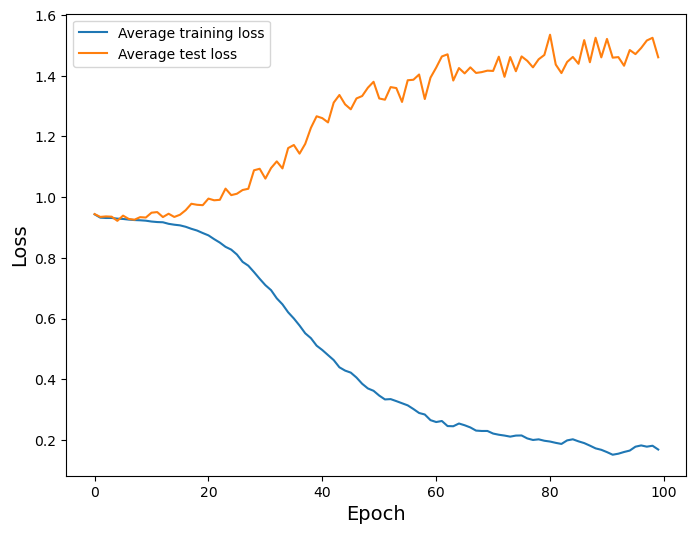

In [184]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
plt.close()

In [182]:
to_send = model(blind_data_X_features).cpu().numpy()

df_to_send = pd.DataFrame(to_send)
df.to_csv("my_file_group_N",index=False) # Replace "N" with the group number we assigned you


NameError: name 'blind_data_X_features' is not defined

# Practical instructions

- Divide yourselves in groups of three. Once the groups are defined, we will assign you a numerical label.
- Each group will have to send the csv file mentioned above as an attached `.csv`file to [lisbon-ml-workshop@cern.ch](mailto:lisbon-ml-workshop@cern.ch). The email (ONE EMAIL PER GROUP) must have:
  - As an object: "LIP ML Workshop Data Challenge: Group N", where "N" is the number we assigned you above
  - All the three members of the group must be in carbon copy to the email
  - In the email text there must be a list of the full names of the three members of the project